In [1]:
%matplotlib inline

In [2]:
import os, sys, glob
from pathlib import Path

import numpy as np
from numpy import nan as NaN
import pandas as pd
import matplotlib.pyplot as plt 

# Behavioural analysis

This notebook includes code used to generate figures for behavioural metrics, including response rates and memory performance scores. It also plots the distribution of interval durations between repetition.

It generates the following figures and sub-figures from the datapaper:

* **Fig 1C**, distribution of delays between image repetitions
* **Fig 2C**, response rate
* **Fig 3C**, response types (hits, misses, false alarms and correct rejections per subcondition)
* **Fig S1**, reaction time per response type


In [3]:
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
import matplotlib
print('matplotlib version: ', matplotlib.__version__)

numpy version:  1.21.2
pandas version:  1.3.2
matplotlib version:  3.5.0


## Code to generate Figure 1C 

This plot features the frequency distribution of delays between image repetitions per trial, for each subject.

**Top charts**: delays between repetitions in days. Images were either repeated within session (0 days) or between consecutive sessions, most of which were 7 days apart, with a few exceptions due to participant and scanner availability)

**Bottom charts**: delays between repetitions in seconds, for within-session repetitions only. The red vertical lines indicates 283s, the duration of a single run, to separate within-run (left of the line) and between-run (right of the line) repetitions.


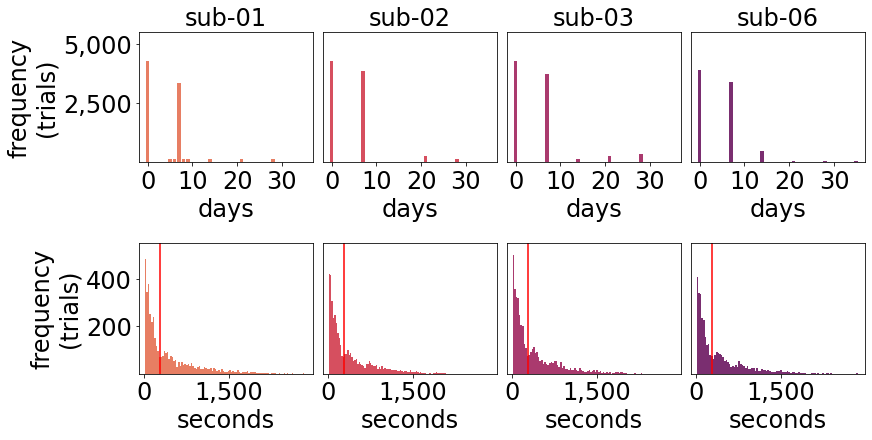

In [7]:
# set to True to export .png file
save_fig = False

beh_file_path = Path("../../THINGS/things.behaviour").resolve()
fig_save_path = Path("../figures").resolve()


SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mosaic = """
    ABCD
    ABCD
    ABCD
    ABCD
    ABCD
    ABCD
    ABCD
    ABCD
    ....
    EFGH
    EFGH
    EFGH
    EFGH
    EFGH
    EFGH
    EFGH
    EFGH
    """

fig = plt.figure(constrained_layout=True, figsize=(12, 6))

sub = ['01', '02', '03', '06']
top_idx = ['A', 'B', 'C', 'D']
bottom_idx = ['E', 'F', 'G', 'H']
colors = [
    (0.90732341, 0.4939774, 0.38990532),
    (0.83765537, 0.30784814, 0.3723105),
    (0.66635279, 0.22717328, 0.43008427),
    (0.47936222, 0.18006056, 0.43733022),
]

ax_dict = fig.subplot_mosaic(mosaic)

for i in range(len(sub)):
    s = sub[i]
    top_ref = top_idx[i]
    bottom_ref = bottom_idx[i]
    df = pd.read_csv(
            f"{beh_file_path}/sub-{s}/beh/sub-{s}_task-things_desc-annotation-per-trial_beh.tsv", sep = '\t')
    
    delay, count = np.unique(df['delay_days'].dropna(), return_counts = True)
    
    ax_dict[top_ref].bar(delay, count, color=colors[i])
    ax_dict[top_ref].set_title(f'sub-{s}')
    ax_dict[top_ref].set_xticks(ticks=[0, 10, 20, 30])
    ax_dict[bottom_ref].set_xticks(ticks=[0, 1500])
    
    if i > 0:
        ax_dict[top_ref].set_yticks(ticks=[])
        ax_dict[top_ref].set_ylabel('')
        ax_dict[bottom_ref].set_yticks(ticks=[])
        ax_dict[bottom_ref].set_ylabel('')

    else:
        ax_dict[top_ref].set_yticks(ticks=[2500, 5000], labels=['2,500', '5,000'])
        ax_dict[top_ref].set_ylabel('frequency\n(trials)')
        ax_dict[bottom_ref].set_yticks(ticks=[200, 400])
        ax_dict[bottom_ref].set_ylabel('frequency\n(trials)')
        
    ax_dict[top_ref].set_xlim(-2, 37)
    ax_dict[top_ref].set_ylim(0, 5500)
    ax_dict[top_ref].set_xlabel('days')
    ax_dict[bottom_ref].set_xlim(-100, 3000)
    ax_dict[bottom_ref].set_xticks(ticks=[0, 1500], labels=['0', '1,500'])
    ax_dict[bottom_ref].set_ylim(0, 550)    
    ax_dict[bottom_ref].set_xlabel('seconds')
    
    df = pd.read_csv(
        f"{beh_file_path}/sub-{s}/beh/sub-{s}_task-things_desc-annotation-per-trial_beh.tsv", sep = '\t'
    )
    df = df[~df['delay_seconds'].isna()]
    df = df[df['delay_seconds'] > 0]
    
    ax_dict[bottom_ref].hist(df['delay_seconds'], bins=100, color=colors[i])
    ax_dict[bottom_ref].plot([283, 283], [0, 550], color='red')
    
if save_fig:
    plt.savefig(f'{fig_save_path}/Fig1C_delays_distribution.png', dpi=600)

plt.show()
    

## Code to generate Figure 2C 

This plot features each subject's response rate, that is, the proportion of trials for which a button press was recorded. 

**Figure 2C** from the data paper shows response rates per run, while the figure below includes rates per run and per session for each subject.


In [34]:
beh_file_path = Path("../../THINGS/things.behaviour").resolve()
fig_save_path = Path("../figures").resolve()


In [8]:
# Extract response rate per run and session for each subject

flist = sorted(glob.glob(f"{beh_file_path}/sub-*/beh/sub-*_task-things_desc-annotation-per-trial_beh.tsv"))

rr_per_sess_allsub = []
rr_per_run_allsub = []

for file in flist:
    df = pd.read_csv(file, sep = '\t')[['image_category', 'image_name', 'session', 'run', 'response_txt']]

    runs_w_missing_trials = 0
    sessions = np.unique(df['session']).tolist()
     
    rr_per_sess = []
    rr_per_run = []
    
    for s in sessions:
        df_s = df[df['session']==s]
        rate_na_s = 1 - (np.sum(df_s['response_txt'].isna()) / df_s.shape[0])
        rr_per_sess.append(rate_na_s)

        runs = np.unique(df_s['run']).tolist()
        for r in runs:
            df_sr = df_s[df_s['run']==r]
            rate_na_r = 1 - (np.sum(df_sr['response_txt'].isna()) / df_sr.shape[0])
            rr_per_run.append(rate_na_r)
            
    rr_per_sess_allsub.append(rr_per_sess)
    rr_per_run_allsub.append(rr_per_run)

for rr_list in rr_per_run_allsub:
    print(np.mean(rr_list), np.std(rr_list), np.median(rr_list)) 
    

0.9112676056338028 0.13960526309092508 0.9833333333333333
0.9981220657276995 0.021945532192526287 1.0
0.9983568075117372 0.017278653727303233 1.0
0.9917948717948718 0.01674079504431487 1.0


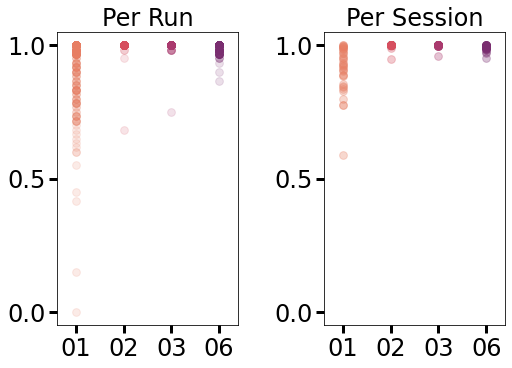

In [16]:
# Make figure

# set to True to export .png file
save_fig = False

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


mosaic = """
    AAAAAA.BBBBBB
    """

fig = plt.figure(constrained_layout=True, figsize=(7, 5))
ax_dict = fig.subplot_mosaic(mosaic)

sub = ['01', '02', '03', '06']
colors = [
    (0.90732341, 0.4939774, 0.38990532),
    (0.83765537, 0.30784814, 0.3723105),
    (0.66635279, 0.22717328, 0.43008427),
    (0.47936222, 0.18006056, 0.43733022),
]

for i in range(len(rr_per_run_allsub)):
    ax_dict["A"].scatter(np.repeat(i, len(rr_per_run_allsub[i])), rr_per_run_allsub[i], s=60, alpha=0.15, color=colors[i])
    ax_dict["B"].scatter(np.repeat(i, len(rr_per_sess_allsub[i])), rr_per_sess_allsub[i], s=60, alpha=0.3, color=colors[i])

    
ax_dict["A"].set_xticks([0, 1, 2, 3])
ax_dict["A"].set_xlim(-0.4, 3.4)
ax_dict["A"].set_ylim(-0.05, 1.05)
ax_dict["A"].set_xticklabels(['01', '02', '03', '06'])
ax_dict["A"].set_yticks([0, 0.5, 1.0])
ax_dict["A"].set_title('Per Run')
ax_dict["A"].tick_params(width=3, size=8)

ax_dict["B"].set_xticks([0, 1, 2, 3])
ax_dict["B"].set_xlim(-0.4, 3.4)
ax_dict["B"].set_ylim(-0.05, 1.05)
ax_dict["B"].set_xticklabels(['01', '02', '03', '06'])
ax_dict["B"].set_yticks([0, 0.5, 1.0])
ax_dict["B"].set_title('Per Session')
ax_dict["B"].tick_params(width=3, size=8)

if save_fig:
    plt.savefig(f'{fig_save_path}/Fig2C_response_rate.png', dpi=600)
plt.show()


## Code to generate Figure 3 

This plot features performance metric on the image recognition task for each subject, as a whole and per sub-condition. 

**On the left**: proportion of “seen” responses for the 1st image presentation (grey; “seen” answers are false alarms), and for the 2nd and 3rd image presentations (purple and green, respectively; “seen” answers are hits). For presentations 2 and 3, response rates are split between images repeated within (w, darker shades) and between (b, paler shades) sessions. Scores are averaged across sessions for each subject; error bars are standard deviations. 

**On the right**: proportion of answer types per image repetition (1st, 2nd and 3rd presentation), averaged across sessions for each subject. Responses include “seen” and “unseen” answers split between low and high confidence (LC and HC). Error bars are standard deviations. For the 2nd and 3rd presentation, results are split between images repeated within (w) and between (b) sessions. “Seen” answers (darker blue: high confidence; pale blue: low confidence) are incorrect一false alarms一for presentation 1, and correct一hits一for presentations 2 and 3. “Unseen” answers (red: high confidence; pink: low confidence) are correct一correct rejections一for presentation 1, and incorrect一misses一for presentations 2 and 3. 


In [21]:
# concatenate metrics per session across all subjects

beh_file_path = Path("../../THINGS/things.behaviour").resolve()
fig_save_path = Path("../figures").resolve()

flist = sorted(glob.glob(f"{beh_file_path}/sub-*/beh/sub-0*_task-things_desc-score-per-session_beh.tsv"))

sess_df = None
for file in flist:
    sub_df = pd.read_csv(file, sep='\t')
    sess_df = sub_df if sess_df is None else pd.concat([sess_df, sub_df], ignore_index=True)
        

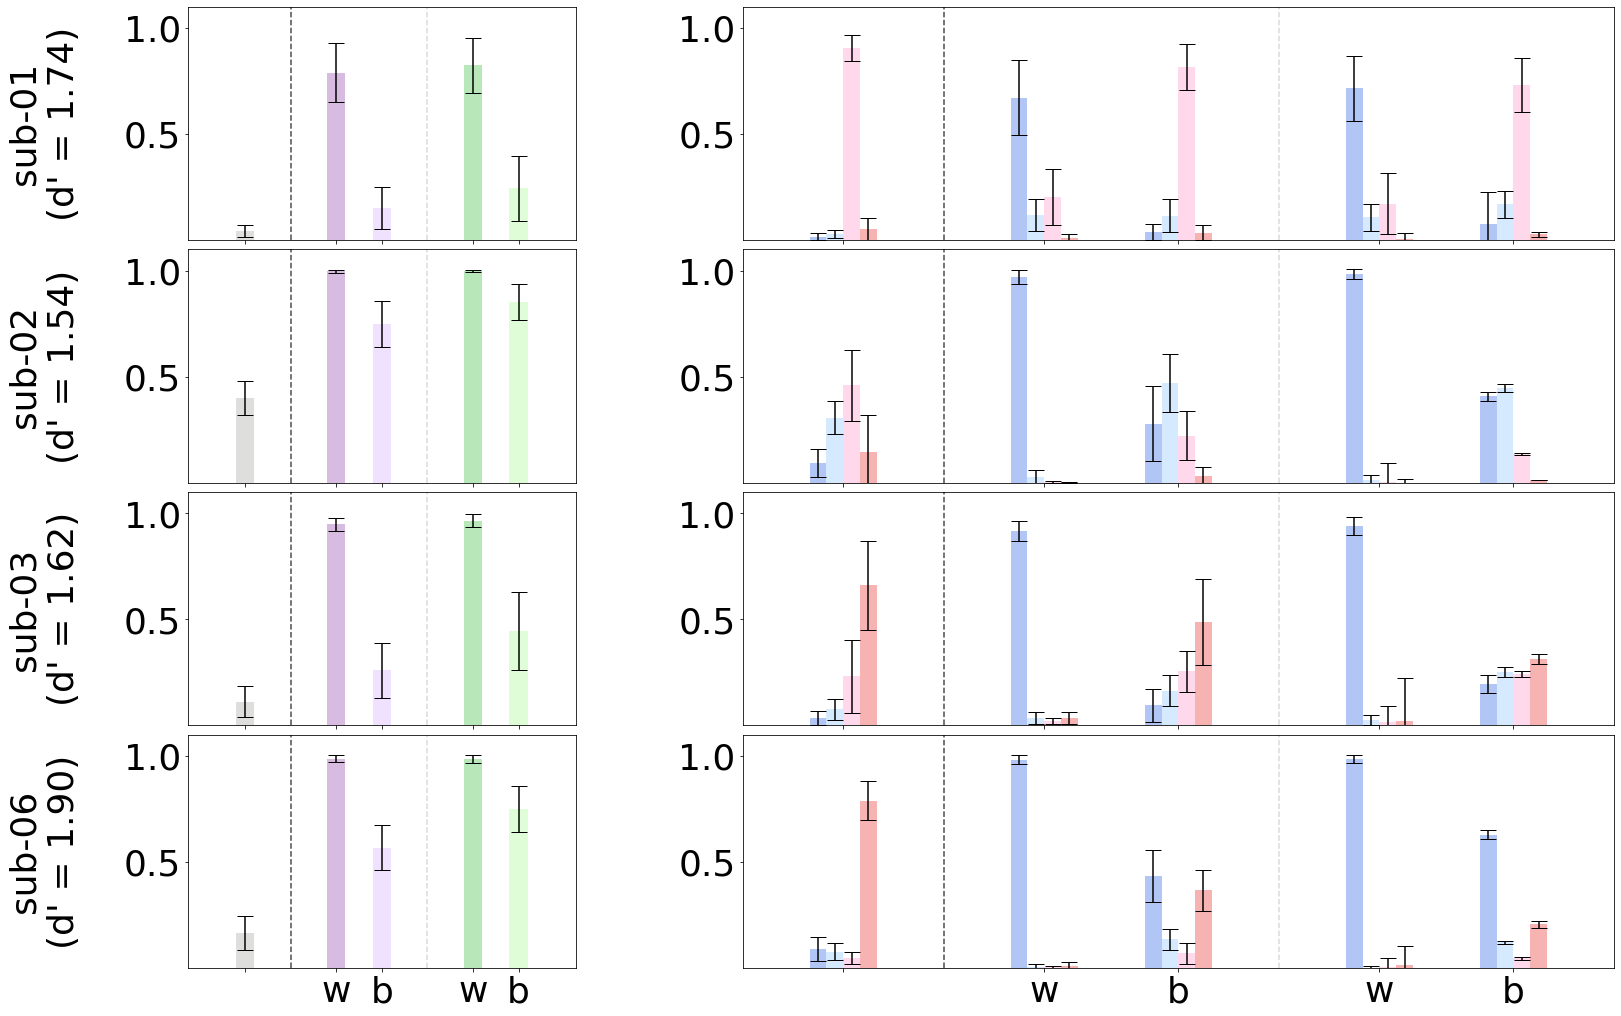

In [37]:
# Composite Figure: average counts per response type, overall and per subcondition

# set to True to export .png file
fig_save = False
standard_error = False  # error bars are standard deviation if False, standard error of the mean if True


SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 36
BIGGEST_SIZE=36 

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGEST_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mosaic = """
    AAAA.EEEEEEEEE
    BBBB.FFFFFFFFF
    CCCC.GGGGGGGGG
    DDDD.HHHHHHHHH
    """

fig = plt.figure(constrained_layout=True, figsize=(22.4, 3.5*4))
ax_dict = fig.subplot_mosaic(mosaic)

sub_list = np.unique(sess_df['subject']).tolist()
ref_list1 = ["A", "B", "C", "D"]
ref_list2 = ["E", "F", "G", "H"]
dprime = ['1.74', '1.54', '1.62', '1.90']

for i in range(len(sub_list)):
    sub = sub_list[i]
    
    # Left-hand plots
    df = sess_df[sess_df['subject'] == sub][['false_alarm', 'new',
                                             'hit_within', 'hit_between',
                                             'hit_within_between', 'hit_between_within',
                                             'old_within', 'old_between', 'old_within_between',
                                             'old_between_within', 
                                             'session']]
    
    df = df[df['session'] != 'ses-001']  # exclude season 1 from analyses: no between-session repeats
    sq = np.sqrt(df.shape[0]) if standard_error else 1.0
    
    ref1 = ref_list1[i]
    ref2 = ref_list2[i]
    
    fa = (df['false_alarm'] / df['new']).mean()
    hit_w = (df['hit_within'] / df['old_within']).mean()
    hit_b = (df['hit_between'] / df['old_between']).mean()
    hit_wb = (df['hit_within_between'] / df['old_within_between']).mean()
    hit_bw = (df['hit_between_within'] / df['old_between_within']).mean()

    fa_w_se = (df['false_alarm'] / df['new']).std()/sq
    hit_w_se = (df['hit_within'] / df['old_within']).std()/sq
    hit_b_se = (df['hit_between'] / df['old_between']).std()/sq
    hit_wb_se = (df['hit_within_between'] / df['old_within_between']).std()/sq
    hit_bw_se = (df['hit_between_within'] / df['old_between_within']).std()/sq
    
    w = 0.4    # bar width
    x = [1, 3, 4, 6, 7] # x-coordinates of your bars
    colors = ['xkcd:grey', 'xkcd:purple', 'xkcd:lilac', 'xkcd:green', 'xkcd:light green',]
    y = [fa, hit_w, hit_b, hit_bw, hit_wb]
    y_se = [fa_w_se, hit_w_se, hit_b_se, hit_bw_se, hit_wb_se]

    tick_label = ["", "w", "b", "w", "b"] if i ==3 else ["", "", "", "", ""]
    ax_dict[ref1].bar(x,
                     height=y,
                     capsize=8, # error bar cap width in points
                     width=w,    # bar width
                     tick_label=tick_label,
                     color = colors,
                     alpha=0.3,
                     yerr=y_se
                    )
    
    ax_dict[ref1].plot([2, 2], [0, 1.1], c='black', linestyle='dashed', alpha=0.7)
    ax_dict[ref1].plot([5, 5], [0, 1.1], c='black', linestyle='dashed', alpha=0.15)

    ax_dict[ref1].set_ylim((0, 1.1))
    ax_dict[ref1].set_xlim((-0.25, 8.25))
    ax_dict[ref1].set_yticks((0.5, 1.0))
    ax_dict[ref1].set_ylabel(f"sub-0{sub[-1]}\n(d' = {dprime[i]})\n")
    
    
    # Right-hand plots
    df = sess_df[sess_df['subject'] == sub][['hit_within_loConf', 'hit_within_hiConf', 
                                             'hit_between_loConf', 'hit_between_hiConf',
                                             'miss_within_loConf', 'miss_within_hiConf',
                                             'miss_between_loConf', 'miss_between_hiConf',
                                             'hit_within_between_loConf', 'hit_within_between_hiConf', 
                                             'hit_between_within_loConf', 'hit_between_within_hiConf',
                                             'miss_within_between_loConf', 'miss_within_between_hiConf',
                                             'miss_between_within_loConf', 'miss_between_within_hiConf',
                                             'CR_loConf', 'CR_hiConf',
                                             'FA_loConf', 'FA_hiConf', 
                                             'old_within', 'old_between', 
                                             'old_within_between', 'old_between_within',
                                             'new', 'session']]#.dropna()
    
    df = df[df['session'] != 'ses-001']  # exclude session 1
    sq = np.sqrt(df.shape[0]) if standard_error else 1.0
    
    hitw_lc = (df['hit_within_loConf'] / df['old_within']).mean()
    hitw_hc = (df['hit_within_hiConf'] / df['old_within']).mean()
    missw_lc = (df['miss_within_loConf'] / df['old_within']).mean()
    missw_hc = (df['miss_within_hiConf'] / df['old_within']).mean()

    hitb_lc = (df['hit_between_loConf'] / df['old_between']).mean()
    hitb_hc = (df['hit_between_hiConf'] / df['old_between']).mean()
    missb_lc = (df['miss_between_loConf'] / df['old_between']).mean()
    missb_hc = (df['miss_between_hiConf'] / df['old_between']).mean()

    
    hitwb_lc = (df['hit_within_between_loConf'] / df['old_within_between']).mean()
    hitwb_hc = (df['hit_within_between_hiConf'] / df['old_within_between']).mean()
    misswb_lc = (df['miss_within_between_loConf'] / df['old_within_between']).mean()
    misswb_hc = (df['miss_within_between_hiConf'] / df['old_within_between']).mean()

    hitbw_lc = (df['hit_between_within_loConf'] / df['old_between_within']).mean()
    hitbw_hc = (df['hit_between_within_hiConf'] / df['old_between_within']).mean()
    missbw_lc = (df['miss_between_within_loConf'] / df['old_between_within']).mean()
    missbw_hc = (df['miss_between_within_hiConf'] / df['old_between_within']).mean()
        

    cr_lc = (df['CR_loConf'] / df['new']).mean()
    cr_hc = (df['CR_hiConf'] / df['new']).mean()
    fa_lc = (df['FA_loConf'] / df['new']).mean()
    fa_hc = (df['FA_hiConf'] / df['new']).mean()

    sure_old = [fa_hc, hitw_hc, hitb_hc, hitbw_hc, hitwb_hc]
    guess_old = [fa_lc, hitw_lc, hitb_lc, hitbw_lc, hitwb_lc]
    guess_new = [cr_lc, missw_lc, missb_lc, missbw_lc, misswb_lc]
    sure_new = [cr_hc, missw_hc, missb_hc, missbw_hc, misswb_hc]

    hitw_lc_se = (df['hit_within_loConf'] / df['old_within']).std()/sq
    hitw_hc_se = (df['hit_within_hiConf'] / df['old_within']).std()/sq
    missw_lc_se = (df['miss_within_loConf'] / df['old_within']).std()/sq
    missw_hc_se = (df['miss_within_hiConf'] / df['old_within']).std()/sq

    hitb_lc_se = (df['hit_between_loConf'] / df['old_between']).std()/sq
    hitb_hc_se = (df['hit_between_hiConf'] / df['old_between']).std()/sq
    missb_lc_se = (df['miss_between_loConf'] / df['old_between']).std()/sq
    missb_hc_se = (df['miss_between_hiConf'] / df['old_between']).std()/sq

    
    hitwb_lc_se = (df['hit_within_between_loConf'] / df['old_within_between']).std()/sq
    hitwb_hc_se = (df['hit_within_between_hiConf'] / df['old_within_between']).std()/sq
    misswb_lc_se = (df['miss_within_between_loConf'] / df['old_within_between']).std()/sq
    misswb_hc_se = (df['miss_within_between_hiConf'] / df['old_within_between']).std()/sq

    hitbw_lc_se = (df['hit_between_within_loConf'] / df['old_between_within']).std()/sq
    hitbw_hc_se = (df['hit_between_within_hiConf'] / df['old_between_within']).std()/sq
    missbw_lc_se = (df['miss_between_within_loConf'] / df['old_between_within']).std()/sq
    missbw_hc_se = (df['miss_between_within_hiConf'] / df['old_between_within']).std()/sq
        
    
    cr_lc_se = (df['CR_loConf'] / df['new']).std()/sq
    cr_hc_se = (df['CR_hiConf'] / df['new']).std()/sq
    fa_lc_se = (df['FA_loConf'] / df['new']).std()/sq
    fa_hc_se = (df['FA_hiConf'] / df['new']).std()/sq

    sure_old_se = [fa_hc_se, hitw_hc_se, hitb_hc_se, hitbw_hc_se, hitbw_hc_se]
    guess_old_se = [fa_lc_se, hitw_lc_se, hitb_lc_se, hitbw_lc_se, hitbw_lc_se]
    guess_new_se = [cr_lc_se, missw_lc_se, missb_lc_se, misswb_lc_se, missbw_lc_se]
    sure_new_se = [cr_hc_se, missw_hc_se, missb_hc_se, misswb_hc_se, missbw_hc_se]
    

    X = np.array([1, 2.5, 3.5, 5, 6])
    capsize=8
    
    ax_dict[ref2].bar(X + -0.1875, sure_old, capsize=capsize, color = 'xkcd:blue', alpha=0.3,
                      yerr=sure_old_se, width = 0.125, label = '"Seen" HC')
    ax_dict[ref2].bar(X + -0.0625, guess_old, capsize=capsize, color = 'xkcd:sky blue', alpha=0.3,
                      yerr=guess_old_se, width = 0.125, label = '"Seen" LC')
    ax_dict[ref2].bar(X + 0.0625, guess_new, capsize=capsize, color = 'xkcd:pink', alpha=0.3, 
                      yerr=guess_new_se, width = 0.125, label = '"Unseen" LC')
    ax_dict[ref2].bar(X + 0.1875, sure_new, capsize=capsize, color = 'xkcd:red', alpha=0.3, 
                      yerr=sure_new_se, width = 0.125, label = '"Unseen" HC')
    
    ax_dict[ref2].plot([1.75, 1.75], [0, 1.1], c='black', linestyle='dashed', alpha=0.7)
    ax_dict[ref2].plot([4.25, 4.25], [0, 1.1], c='black', linestyle='dashed', alpha=0.15)
    
    ax_dict[ref2].set_ylim((0, 1.1))
    ax_dict[ref2].set_xlim((0.25, 6.75))
    ax_dict[ref2].set_yticks((0.5, 1.0))
    
    ax_dict[ref2].set_xticks(X)
    tick_label = ["", "w", "b", "w", "b"] if i ==3 else ["", "", "", "", ""]
    ax_dict[ref2].set_xticklabels(tick_label)
    
    
if fig_save:
    plt.savefig(f'{fig_save_path}/Figure3_Hit_Miss_FA_CR_counts.jpg', dpi=600)
plt.show()



## Code to generate supplementary Figure S1

Figure S1 features reaction time (in seconds) per response type averaged across sessions for each subject. Reaction time is shown for hits, misses, correct rejections (CR) and false alarms (FA). Hit and Miss reaction times are shown separately for within-session (pale) and between-session (dark) repetitions. Error bars represent the standard deviation.


In [4]:
# concatenate metrics per session across all subjects

beh_file_path = Path("../../THINGS/things.behaviour").resolve()
fig_save_path = Path("../figures").resolve()

flist = sorted(glob.glob(f"{beh_file_path}/sub-*/beh/sub-0*_task-things_desc-score-per-session_beh.tsv"))

sess_df = None
for file in flist:
    sub_df = pd.read_csv(file, sep='\t')
    sess_df = sub_df if sess_df is None else pd.concat([sess_df, sub_df], ignore_index=True)
        

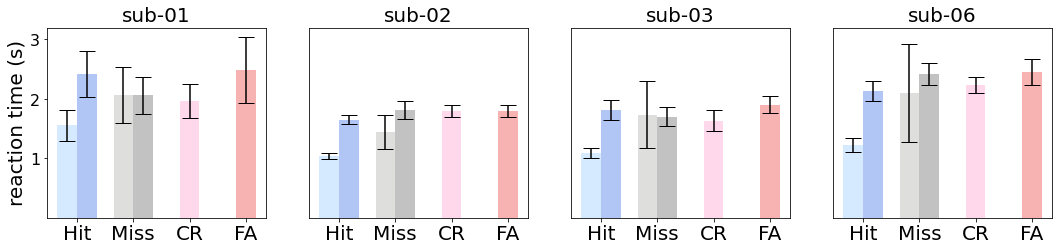

In [6]:
# responses split for within- and between-session repetitions for Hits and Misses

# set to True to export .png file
save_fig = False
standard_error = False  # error bars are standard deviation if False, standard error of the mean if True

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE=20 

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGEST_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axes = plt.subplots(1, 4, figsize=(18, 3.5))

sub_list = sorted(np.unique(sess_df['subject']).tolist())

for i in range(len(sub_list)):
    sub = sub_list[i]
    df = sess_df[sess_df['subject'] == sub][
        ['rt_hit_within', 'rt_hit_between', 'rt_miss_within', 'rt_miss_between', 'rt_CR', 'rt_FA', 'session']
        #['rt_hit', 'rt_miss', 'rt_CR', 'rt_FA', 'session']
    ]
    df = df[df['session'] != 'ses-001']  # exclude session 1
    sq = np.sqrt(df.shape[0]) if standard_error else 1.0
    
    hit_w_rt = df['rt_hit_within'].dropna().mean()
    hit_b_rt = df['rt_hit_between'].dropna().mean()
    miss_w_rt = df['rt_miss_within'].dropna().mean()
    miss_b_rt = df['rt_miss_between'].dropna().mean()
    CR_rt = df['rt_CR'].dropna().mean()
    FA_rt = df['rt_FA'].dropna().mean()

    hit_w_se = df['rt_hit_within'].dropna().std()/sq
    hit_b_se = df['rt_hit_between'].dropna().std()/sq
    miss_w_se = df['rt_miss_within'].dropna().std()/sq
    miss_b_se = df['rt_miss_between'].dropna().std()/sq
    CR_se = df['rt_CR'].dropna().std()/sq
    FA_se = df['rt_FA'].dropna().std()/sq
    
    w = 0.35    # bar width
    x = [1-(w/2), 1+(w/2), 2-(w/2), 2+(w/2), 3, 4] # x-coordinates of your bars
    colors = ['xkcd:sky blue', 'xkcd:blue', 'xkcd:grey', 'xkcd:dark grey', 'xkcd:pink', 'xkcd:red',]
    y = [hit_w_rt, hit_b_rt, miss_w_rt, miss_b_rt, CR_rt, FA_rt]
    y_se = [hit_w_se, hit_b_se, miss_w_se, miss_b_se, CR_se, FA_se]
    
    axes[i].bar(x,
                height=y,
                capsize=8, # error bar cap width in points
                width=w,    # bar width
                color = colors,
                alpha=0.3,
                yerr=y_se
               )

    axes[i].set_xticks([1.0, 2.0, 3.0, 4.0], ["Hit", "Miss", "CR", "FA"])    
    axes[i].set_ylim((0, 3.2))
    if i == 0:
        axes[i].set_yticks((1.0, 2.0, 3.0))
        axes[i].set_ylabel('reaction time (s)')
    else:
        axes[i].set_yticks([])
        axes[i].set_ylabel('')        

    axes[i].set_title(f'sub-0{sub[-1]}')
             
if save_fig:
    plt.savefig(f'{fig_save_path}/FigureS1_reaction_times_per_responsetype.png', dpi=600)
plt.show()


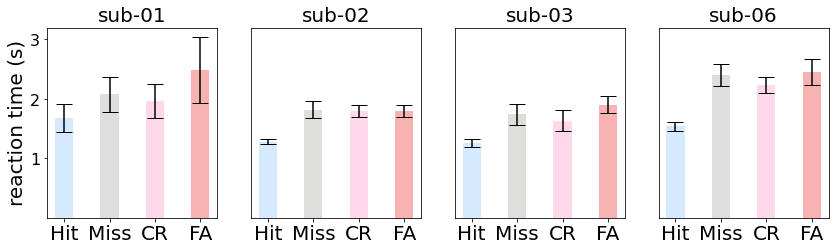

In [51]:
# Responses collapsed for all Hit and Miss responses

# set to True to export .png file
save_fig = False
standard_error = False  # error bars are standard deviation if False, standard error of the mean if True

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE=20 

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGEST_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

sub_list = sorted(np.unique(sess_df['subject']).tolist())

for i in range(len(sub_list)):
    sub = sub_list[i]
    df = sess_df[sess_df['subject'] == sub][['rt_hit', 'rt_miss', 'rt_CR', 'rt_FA', 'session']]
    df = df[df['session'] != 'ses-001']  # exclude session 1
    sq = np.sqrt(df.shape[0]) if standard_error else 1.0
    
    hit_rt = df['rt_hit'].dropna().mean()
    miss_rt = df['rt_miss'].dropna().mean()
    CR_rt = df['rt_CR'].dropna().mean()
    FA_rt = df['rt_FA'].dropna().mean()

    hit_se = df['rt_hit'].dropna().std()/sq
    miss_se = df['rt_miss'].dropna().std()/sq
    CR_se = df['rt_CR'].dropna().std()/sq
    FA_se = df['rt_FA'].dropna().std()/sq
    
    w = 0.4    # bar width
    x = [1, 2, 3, 4] # x-coordinates of your bars
    colors = ['xkcd:sky blue', 'xkcd:grey', 'xkcd:pink', 'xkcd:red',]
    y = [hit_rt, miss_rt, CR_rt, FA_rt]
    y_se = [hit_se, miss_se, CR_se, FA_se]

    axes[i].bar(x,
                height=y,
                capsize=8, # error bar cap width in points
                width=w,    # bar width
                tick_label=["Hit", "Miss", "CR", "FA"],
                color = colors,
                alpha=0.3,
                yerr=y_se
               )
                  
    axes[i].set_ylim((0, 3.2))
    if i == 0:
        axes[i].set_yticks((1.0, 2.0, 3.0))
        axes[i].set_ylabel('reaction time (s)')
    else:
        axes[i].set_yticks([])
        axes[i].set_ylabel('')        

    axes[i].set_title(f'sub-0{sub[-1]}')
             
if save_fig:
    plt.savefig(f'{fig_save_path}/FigureS1_reaction_times_per_responsetype.png', dpi=600)
plt.show()
